In [1]:
#대학평가(kaggle에서 수집한 데이터를 가공하여 실습)
import pandas as pd
df = pd.read_csv("c:/data/school/data.csv")
df.head()

,teaching,international,research,citations,income,num_students,student_staff_ratio,international_students,total_score,Label
0,12.4,95.6,10.6,13.3,33.3,5226,14.1,0.82,59.8,0
1,29.9,90.1,20.1,65.3,33.9,2473,15.6,0.63,59.8,0
2,24.7,82.6,18.9,43.5,28.4,2473,15.6,0.63,59.8,0
3,61.3,98.6,67.5,94.6,65.4,9666,10.5,0.54,76.1,1
4,62.4,98.8,57.0,95.0,49.8,9666,10.5,0.54,73.0,1


In [2]:
train_cols = df.columns[0:8]
print(train_cols)
X = df[train_cols] # 독립변수
y = df["Label"] # 종속변수

Index(['teaching', 'international', 'research', 'citations', 'income',
       'num_students', 'student_staff_ratio', 'international_students'],
      dtype='object')


In [3]:
df["Label"].value_counts()

0    2158
1     445
Name: Label, dtype: int64

c:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '분류\n (0: bad, 1: good)')

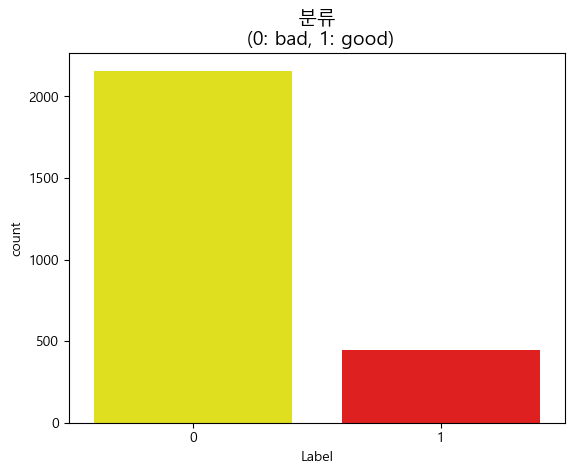

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import seaborn as sns
colors = ["yellow", "red"]
sns.countplot('Label', data=df, palette=colors)
plt.title('분류\n (0: bad, 1: good)', fontsize=14)
#불균형 데이터셋

In [5]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=train_cols )
y_samp = pd.DataFrame(data=y_sample,columns=['Label'])
df_samp=pd.concat([X_samp,y_samp],axis=1)
df_samp["Label"].value_counts()

0    445
1    445
Name: Label, dtype: int64

In [6]:
X=df_samp[train_cols]
y=df_samp["Label"]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=10)

In [8]:
#로지스틱 회귀분석
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=10,max_iter=1000)
logit.fit(X_train, y_train)
print("학습용:",logit.score(X_train, y_train))
print("검증용:",logit.score(X_test, y_test))

학습용: 0.8862359550561798
검증용: 0.8651685393258427


In [9]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [10]:
#다양한 알고리즘별 정확도를 저장할 리스트
result_tr=[]
result_te=[]

In [11]:
logit = LogisticRegression(random_state=10)
logit.fit(X_train_scaled, y_train)
score_tr=logit.score(X_train_scaled, y_train)
score_te=logit.score(X_test_scaled, y_test)
print("학습용:",score_tr)
print("검증용:",score_te)
result_tr.append(score_tr)
result_te.append(score_te)

학습용: 0.9887640449438202
검증용: 0.9943820224719101


In [12]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=10)
tree.fit(X_train_scaled, y_train)
print("학습용:",tree.score(X_train_scaled, y_train))
print("검증용:",tree.score(X_test_scaled, y_test))

학습용: 1.0
검증용: 0.9719101123595506


In [13]:
# max_depth 가지치기
tree = DecisionTreeClassifier(max_depth=4, random_state=10)
tree.fit(X_train_scaled, y_train)
score_tr=tree.score(X_train_scaled, y_train)
score_te=tree.score(X_test_scaled, y_test)
print("학습용:",score_tr)
print("검증용:",score_te)

학습용: 0.9789325842696629
검증용: 0.9775280898876404


In [14]:
result_tr.append(score_tr)
result_te.append(score_te)

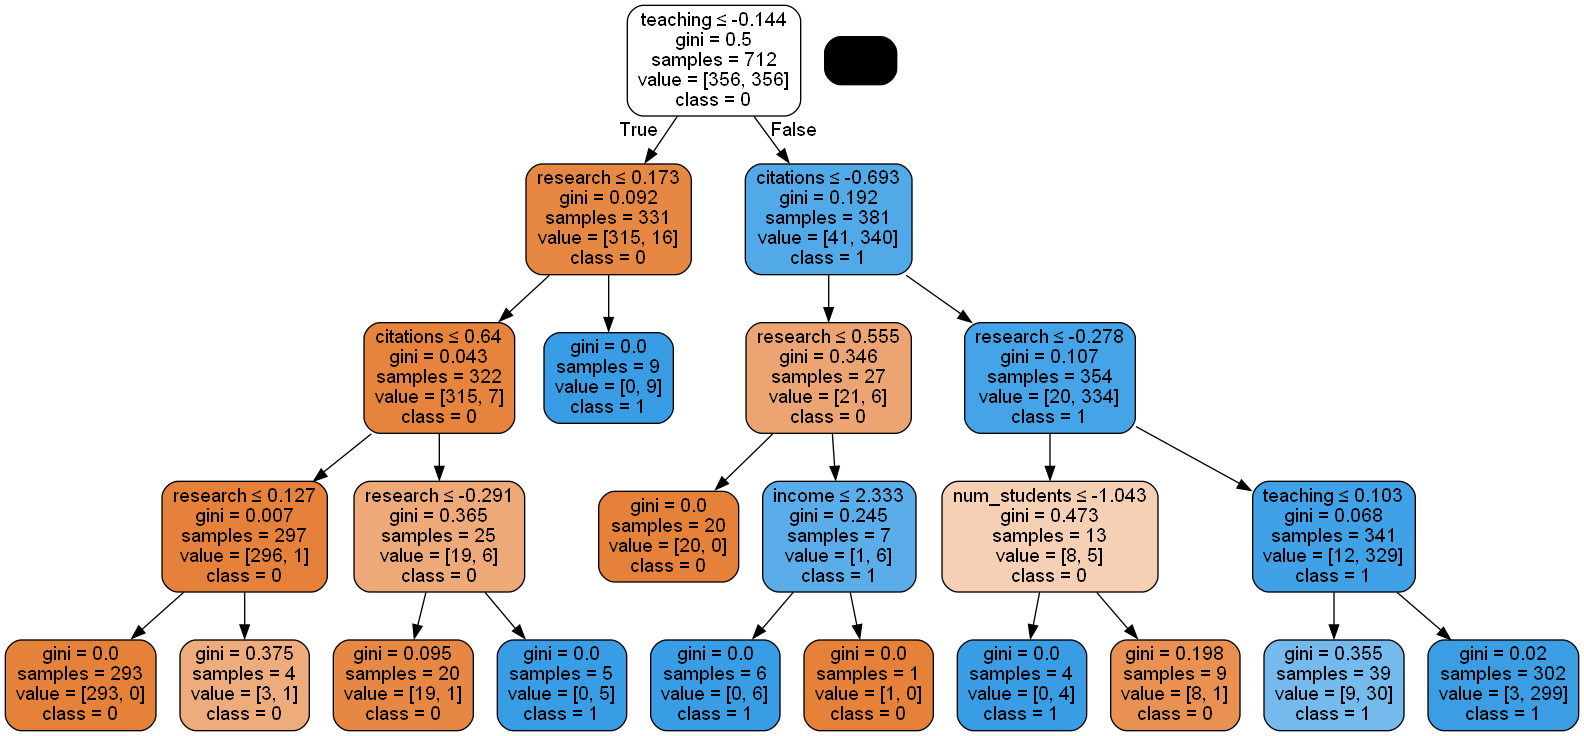

In [15]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
dot_data = export_graphviz(tree, out_file=None, feature_names=train_cols, class_names=["0","1"], 
                           filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [16]:
#트리를 만드는 결정에 각 특성이 얼마나 중요한지를 평가하는 특성 중요도 적용
#0~1 사이의 값(0 전혀 사용되지 않음 ~ 1 완벽하게 타겟 클래스 예측)
import numpy as np
def plot_tree(model):
    n_features = X.shape[1]
    plt.rcParams["figure.figsize"]=(16,9)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train_cols)
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)
    plot_tree(tree)
    #특성 중요도 :

In [17]:
#랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
#100개의 트리로 구성된 랜덤 포레스트
forest = RandomForestClassifier(n_estimators=100, random_state=10)
forest.fit(X_train_scaled, y_train)
score_tr=forest.score(X_train_scaled, y_train)
score_te=forest.score(X_test_scaled, y_test)
print("학습용:",score_tr)
print("검증용:",score_te)

학습용: 1.0
검증용: 0.9943820224719101


In [18]:
result_tr.append(score_tr)
result_te.append(score_te)

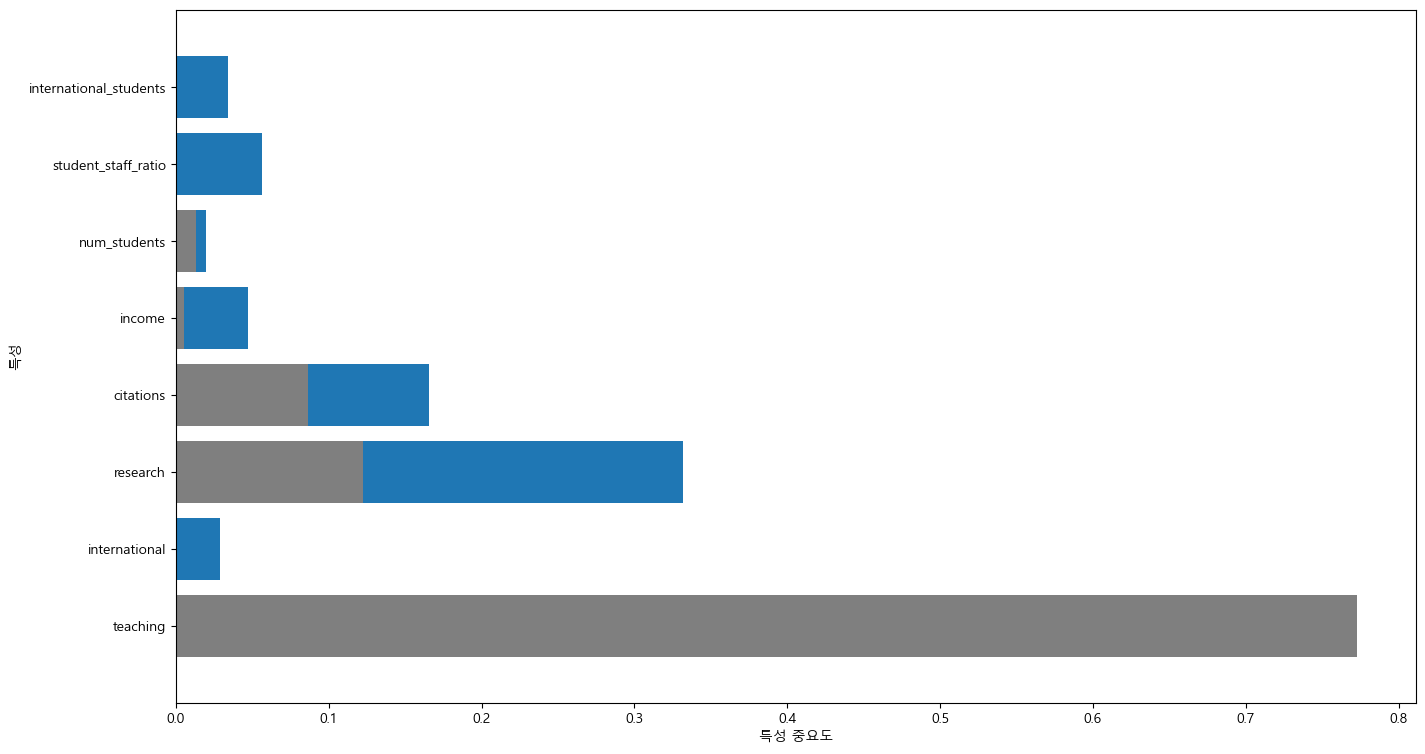

In [19]:
#랜덤 포레스트에서 제공하는 각 트리의 특성 중요도
#랜덤 포레스트는 좀 더 폭넓은 시각으로 데이터를 관찰할 수 있다
plot_tree(forest)
#특성 중요도 :

In [20]:
#knn
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
train_rate = []
test_rate = []
# 새로운 데이터 포인트에 가장 가까운 k개의 이웃을 찾는다.
# k의 값에 따라 결과가 달라지므로 어떤 값이 최적인지 찾아내는 것이 필요함
# 1 에서 10 까지 n_neighbors 를 적용
neighbors = range(1, 11)
for n in neighbors:
# 모델 생성
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_scaled, y_train)
    # 학습용 데이터셋의 정확도
    train_rate.append(knn.score(X_train_scaled, y_train))
    # 검증용 데이터셋의 정확도
    test_rate.append(knn.score(X_test_scaled, y_test))
test_arr=np.array(test_rate) #검증용 데이터셋의 정확도
max_rate=np.max(test_arr) #가장 좋은 정확도
idx=np.where(test_arr == max_rate)[0][0] #가장 성능이 좋은 인덱스
print("최적의 k:",neighbors[idx])
print("최고 정확도:",test_rate[idx])

c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

최적의 k: 5
최고 정확도: 0.9887640449438202


c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

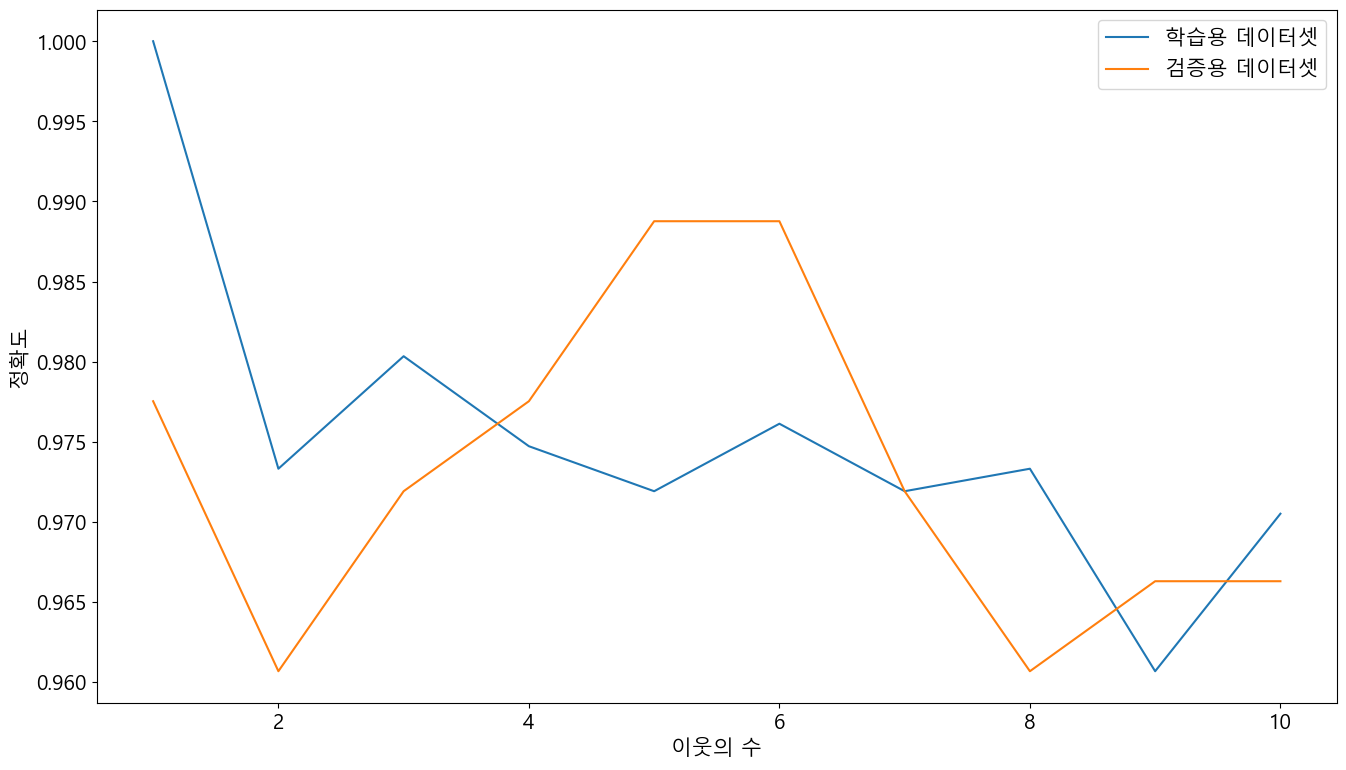

In [21]:
plt.rcParams["font.size"]=15
plt.plot(neighbors, train_rate, label="학습용 데이터셋")
plt.plot(neighbors, test_rate, label="검증용 데이터셋")
plt.ylabel("정확도")
plt.xlabel("이웃의 수")
plt.legend()
#학습용 데이터셋의 경우 이웃이 1개일 때 100% 예측
#이웃의 수가 늘어나면 학습용 데이터셋의 경우 모델이 단순해지고 정확도는 줄어든다.

In [22]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
score_tr=knn.score(X_train_scaled, y_train)
score_te=knn.score(X_test_scaled, y_test)
print("학습용:",score_tr)
print("검증용:",score_te)

학습용: 0.9803370786516854
검증용: 0.9719101123595506


c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

In [23]:
result_tr.append(score_tr)
result_te.append(score_te)

In [24]:
#인공신경망
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=10)
mlp.fit(X_train_scaled, y_train)
print("학습용:",mlp.score(X_train_scaled, y_train))
print("검증용:",mlp.score(X_test_scaled, y_test))

학습용: 0.9943820224719101
검증용: 0.9943820224719101


c:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
score_tr=mlp.score(X_train_scaled, y_train)
score_te=mlp.score(X_test_scaled, y_test)
print("학습용:",score_tr)
print("검증용:",score_te)

학습용: 0.9943820224719101
검증용: 0.9943820224719101


In [26]:
result_tr.append(score_tr)
result_te.append(score_te)

In [27]:
#svm
from sklearn.svm import SVC
svm = SVC(random_state=10)
svm.fit(X_train_scaled, y_train)
print("학습용:",svm.score(X_train_scaled, y_train))
print("검증용:",svm.score(X_test_scaled, y_test))

학습용: 0.9873595505617978
검증용: 0.9887640449438202


In [28]:
#최적의 C value와 gamma value를 찾는 과정
import numpy as np
train_rate = []
test_rate = []
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
g_values = [0.0001, 0.001, 0.01, 0.1]
for n in c_values:
    for g in g_values:
        # 모델 생성
        svm = SVC(C=n,gamma=g,random_state=10)
        svm.fit(X_train_scaled, y_train)
        # 학습용 데이터셋의 정확도
        train_rate.append([n,g,svm.score(X_train_scaled, y_train)])
        # 검증용 데이터셋의 정확도
        test_rate.append([n,g,svm.score(X_test_scaled, y_test)])
train_arr=np.array(train_rate) #검증용 데이터셋의 정확도
test_arr=np.array(test_rate) #검증용 데이터셋의 정확도
max_rate=np.max(test_arr[:,2]) #가장 좋은 정확도
idx=np.argmax(test_arr[:,2]) #가장 성능이 좋은 인덱스
print("최적의 c:",test_rate[idx][0])
print("최적의 gamma:",test_rate[idx][1])
print("최고 정확도:",test_rate[idx][2])

최적의 c: 100
최적의 gamma: 0.01
최고 정확도: 1.0


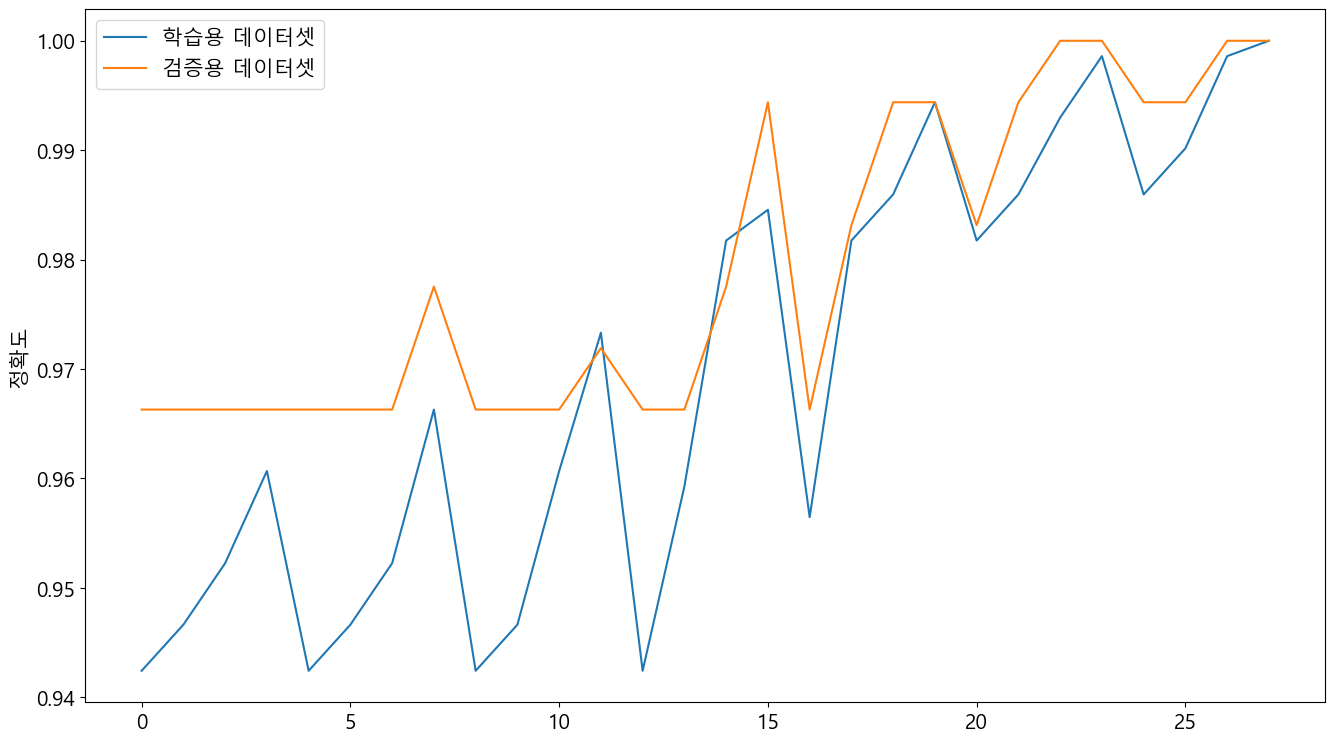

In [29]:
plt.rcParams["font.size"]=15
plt.plot(range(len(train_rate)), train_arr[:,2], label="학습용 데이터셋")
plt.plot(range(len(test_rate)), test_arr[:,2], label="검증용 데이터셋")
plt.ylabel("정확도")
plt.legend()

In [30]:
from sklearn.svm import SVC
svm = SVC(C=1,gamma=0.0001,random_state=10)
svm.fit(X_train_scaled, y_train)
score_tr=svm.score(X_train_scaled, y_train)
score_te=svm.score(X_test_scaled, y_test)
print("학습용:",score_tr)
print("검증용:",score_te)

학습용: 0.9424157303370787
검증용: 0.9662921348314607


In [31]:
result_tr.append(score_tr)
result_te.append(score_te)

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(64,input_shape=(X.shape[1],),activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
sgd = SGD(learning_rate=0.01)  
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
es = EarlyStopping(monitor='val_loss', patience=5)
# 학습 과정에서 만들어진 최적의 파라미터 조합으로 모형을 저장
mc = ModelCheckpoint("school_best.h5", save_best_only=True)
# 학습이 잘 안될 때 학습률을 동적으로 조절하는 옵션
rlr = ReduceLROnPlateau(factor=0.1, patience=5) #기존 학습률*factor (배수)
# 학습 과정의 주요 history를 csv로 저장
csvlogger = CSVLogger("mylog.csv")  
hist = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=500, callbacks=[es, mc, rlr, csvlogger])

Epoch 1/500
18/18 [==============================] - 3s 134ms/step - loss: 0.7185 - accuracy: 0.3902 - val_loss: 0.6811 - val_accuracy: 0.5594 - lr: 0.0100
Epoch 2/500
18/18 [==============================] - 0s 6ms/step - loss: 0.6571 - accuracy: 0.6924 - val_loss: 0.6237 - val_accuracy: 0.8042 - lr: 0.0100
Epoch 3/500
18/18 [==============================] - 0s 7ms/step - loss: 0.6055 - accuracy: 0.8576 - val_loss: 0.5747 - val_accuracy: 0.8881 - lr: 0.0100
Epoch 4/500
18/18 [==============================] - 0s 5ms/step - loss: 0.5606 - accuracy: 0.9051 - val_loss: 0.5313 - val_accuracy: 0.9371 - lr: 0.0100
Epoch 5/500
18/18 [==============================] - 0s 5ms/step - loss: 0.5203 - accuracy: 0.9455 - val_loss: 0.4920 - val_accuracy: 0.9441 - lr: 0.0100
Epoch 6/500
18/18 [==============================] - 0s 6ms/step - loss: 0.4837 - accuracy: 0.9543 - val_loss: 0.4559 - val_accuracy: 0.9510 - lr: 0.0100
Epoch 7/500
18/18 [==============================] - 0s 7ms/step - loss: 0

In [36]:
from keras.models import load_model
model=load_model('school_best.h5')  
model.evaluate(X_test_scaled, y_test, verbose=0)

[0.023808196187019348, 0.9943820238113403]

In [34]:
loss, acc_tr = model.evaluate(X_train_scaled, y_train, verbose=0)
loss, acc_te = model.evaluate(X_test_scaled, y_test, verbose=0)
print("학습용:",acc_tr)
print("검증용:",acc_te)
result_tr.append(acc_tr)
result_te.append(acc_te)

학습용: 0.9943820238113403
검증용: 0.9943820238113403


['LOGIT', 'Tree', 'RF', 'KNN', 'ANN', 'SVM', 'DNN']
[0.9887640449438202, 0.9789325842696629, 1.0, 0.9803370786516854, 0.9943820224719101, 0.9424157303370787, 0.9943820238113403]
[0.9943820224719101, 0.9775280898876404, 0.9943820224719101, 0.9719101123595506, 0.9943820224719101, 0.9662921348314607, 0.9943820238113403]
최적의 모형(학습용): RF
최고 정확도(학습용): 1.0
최적의 모형(검증용): DNN
최고 정확도(검증용): 0.9943820238113403


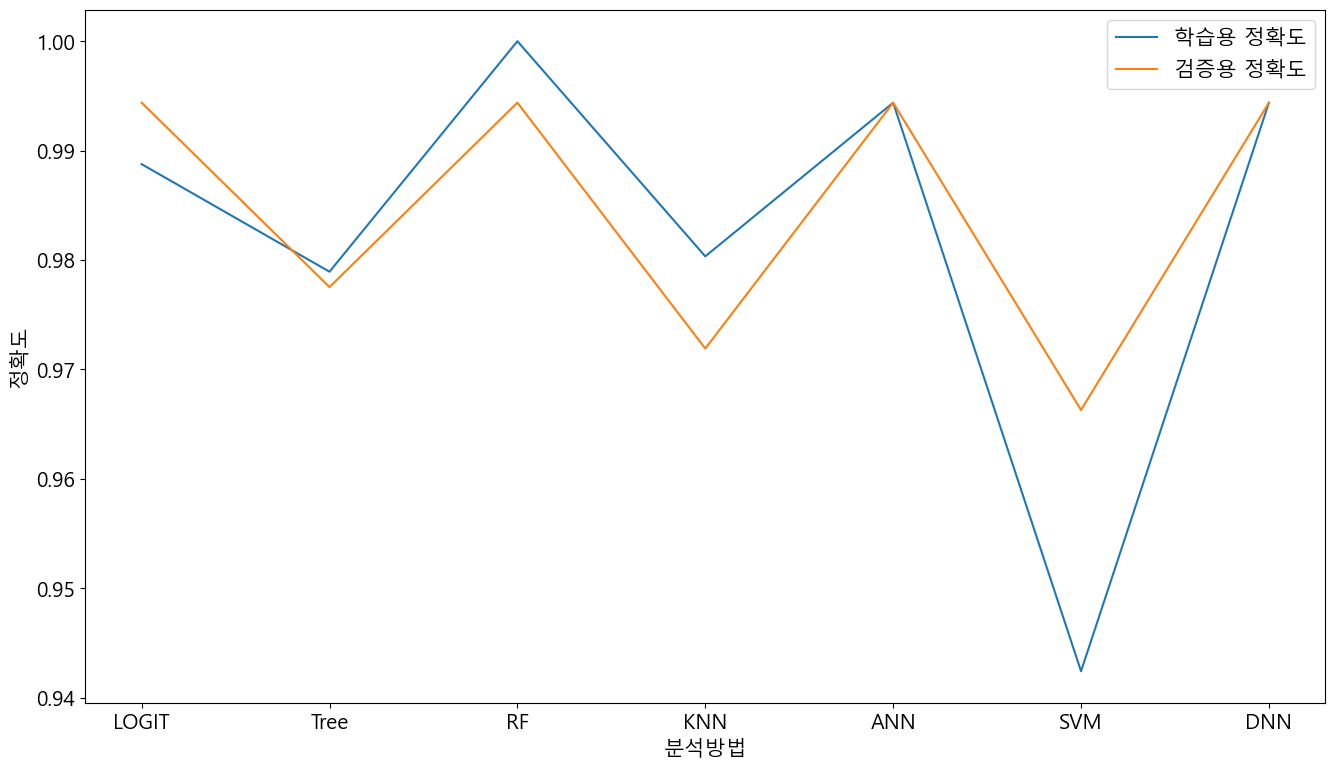

In [35]:
#알고리즘별 예측도 그래프
methods=["LOGIT","Tree","RF","KNN","ANN","SVM","DNN"]
result_tr_arr=np.array(result_tr) #검증용 데이터셋의 정확도
max_rate_tr=np.max(result_tr_arr) #가장 좋은 정확도
idx_tr=np.argmax(result_tr_arr) #가장 성능이 좋은 인덱스
result_te_arr=np.array(result_te) #검증용 데이터셋의 정확도
max_rate_te=np.max(result_te_arr) #가장 좋은 정확도
idx_te=np.argmax(result_te_arr) #가장 성능이 좋은 인덱스
print(methods)
print(result_tr)
print(result_te)
print("최적의 모형(학습용):",methods[idx_tr])
print("최고 정확도(학습용):",max_rate_tr)
print("최적의 모형(검증용):",methods[idx_te])
print("최고 정확도(검증용):",max_rate_te)

plt.rcParams["font.size"]=15
plt.plot(methods, result_tr_arr, label="학습용 정확도")
plt.plot(methods, result_te_arr, label="검증용 정확도")
plt.xlabel("분석방법")
plt.ylabel("정확도")
plt.legend()